## Developing the RF Model

In [261]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score

sns.set()
plt.rcParams["figure.figsize"] = (10, 8)
SEED = 42

train = pd.read_csv("assets/train.csv")
test = pd.read_csv("assets/test.csv")

X = train.copy()
y = X.pop("Survived")

In [262]:
num_features = set([c for c in X.columns if X[c].dtype != "object"])
cat_features = set([c for c in X.columns if c not in num_features])
print("Numerical Features: {}\nCategorical Features: {}".format(num_features, cat_features))

Numerical Features: {'Fare', 'Age', 'Pclass', 'PassengerId', 'Parch', 'SibSp'}
Categorical Features: {'Name', 'Cabin', 'Ticket', 'Sex', 'Embarked'}


#### Pre-Processing

In [263]:
X.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [264]:
X["Age"].fillna(X["Age"].mean(), inplace=True)

In [265]:
X[X["Embarked"].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [266]:
X["Embarked"].value_counts(normalize=True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

In [267]:
X[X["Pclass"] == 1]["Embarked"].value_counts(normalize=True)

S    0.593458
C    0.397196
Q    0.009346
Name: Embarked, dtype: float64

In [268]:
X["Embarked"].fillna(X["Embarked"].mode()[0], inplace=True)

In [269]:
X.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

Deal with missing Cabin values later...

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 11), (179, 11), (712,), (179,))

In [271]:
def create_rf_model():
    return RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=SEED)

In [272]:
def train_score_model(X_train, X_test, y_train, y_test):
    rf = create_rf_model()
    rf.fit(X_train, y_train)
    yhat = rf.predict(X_test)
    
    roc = roc_auc_score(y_test, yhat)
    mse = mean_squared_error(y_test, yhat)
    accuracy = rf.score(X_test, y_test) #r2
    oob_score = rf.oob_score_ #oob
    
    return roc, mse, accuracy, oob_score

### Feature Engineering

In [273]:
X_train.describe() # numerical features only

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,448.234551,2.330056,29.538225,0.553371,0.379213,32.586276
std,256.731423,0.824584,12.994548,1.176404,0.791669,51.969529
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,224.750000,2.000000,22.000000,0.000000,0.000000,7.925000
50%,453.500000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,673.500000,3.000000,35.000000,1.000000,0.000000,30.500000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [274]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,332,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S
733,734,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S
382,383,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S
704,705,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S
813,814,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S


In [275]:
def engineer_numerical_features(df):
    temp = df.copy()
    
    temp["Age"].fillna(temp["Age"].mean(), inplace=True)
    
    temp["Fare"].fillna(temp["Fare"].mean(), inplace=True)
    
    family_size = temp["SibSp"] + temp["Parch"]
    temp["FamilySize"] = family_size
    
    age_class = temp["Age"] * temp["Pclass"]
    temp["AgeClass"] = age_class
    
    return temp


X_train_num = engineer_numerical_features(X_train).drop(columns=cat_features)
X_test_num = engineer_numerical_features(X_test).drop(columns=cat_features)
X_train_num.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,FamilySize,AgeClass
331,332,1,45.5,0,0,28.5000,0,45.5
733,734,2,23.0,0,0,13.0000,0,46.0
382,383,3,32.0,0,0,7.9250,0,96.0
704,705,3,26.0,1,0,7.8542,1,78.0
813,814,3,6.0,4,2,31.2750,6,18.0


In [276]:
X_train_num.isnull().sum().sum(), X_test_num.isnull().sum().sum() # confirm no missing values

(0, 0)

### Train Model - Numerical Only + Added Features

In [277]:
train_score_model(X_train_num, X_test_num, y_train, y_test)

(0.8124195624195624,
 0.1708312290502793,
 0.2955465366795367,
 0.1045799307589006)

### Categorical Variables

In [278]:
train["Name"].str.split(', ', expand=True).head()

,0,1
0,Braund,Mr. Owen Harris
1,Cumings,Mrs. John Bradley (Florence Briggs Thayer)
2,Heikkinen,Miss. Laina
3,Futrelle,Mrs. Jacques Heath (Lily May Peel)
4,Allen,Mr. William Henry


In [279]:
train_titles = train["Name"].str.split(', ', expand=True)[1].str.split(". ", expand=True)[0].value_counts().to_frame().rename(columns={0: "Train"})
train_titles

,Train
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Major,2
Mlle,2
Col,2
th,1


In [280]:
test_titles = test["Name"].str.split(', ', expand=True)[1].str.split(". ", expand=True)[0].value_counts().to_frame().rename(columns={0: "Test"})
test_titles

,Test
Mr,240
Miss,78
Mrs,72
Master,21
Col,2
Rev,2
Dona,1
Ms,1
Dr,1


Determine which titles are unique to train vs. test dataset:

In [281]:
title_counts = pd.concat([train_titles, test_titles], axis=1, sort=True).fillna(0)
title_counts["Total"] = title_counts.sum(axis=1)
title_counts.sort_values(by="Total", ascending=False, inplace=True)
title_counts[["Train", "Test", "Total"]] = title_counts[["Train", "Test", "Total"]].astype("int")
title_counts

,Train,Test,Total
Mr,517,240,757
Miss,182,78,260
Mrs,125,72,197
Master,40,21,61
Rev,6,2,8
Dr,7,1,8
Col,2,2,4
Ms,1,1,2
Major,2,0,2
Mlle,2,0,2


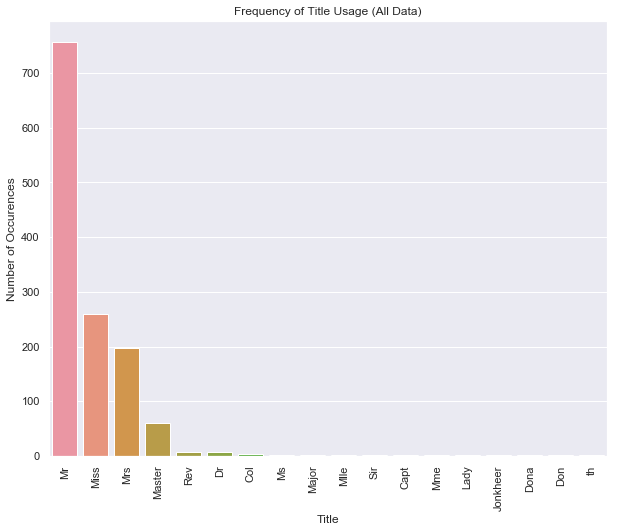

In [282]:
sns.barplot(data=title_counts.reset_index(), x="index", y="Total")
plt.xlabel("Title")
plt.xticks(rotation=90)
plt.ylabel("Number of Occurences")
plt.title("Frequency of Title Usage (All Data)")
plt.show()

In [283]:
title_counts.loc[(title_counts["Total"] <= 1), :]

,Train,Test,Total
Sir,1,0,1
Capt,1,0,1
Mme,1,0,1
Lady,1,0,1
Jonkheer,1,0,1
Dona,0,1,1
Don,1,0,1
th,1,0,1


In [284]:
test.loc[test["Name"].str.contains("Dona")]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
239,1131,1,"Douglas, Mrs. Walter Donald (Mahala Dutton)",female,48.0,1,0,PC 17761,106.425,C86,C
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.900,C105,C


In [285]:
def replace_rare_titles(df):
    title = df["Title"]
    if title in ["Capt", "Col", "Don", "Jonkheer", "Major", "Sir"]:
        return "Mr"
    elif title in ["Mme", "th", "Lady", "Dona"]:
        return 'Mrs'
    elif title in ["Mlle", "Ms"]:
        return 'Miss'
    elif title =='Dr':
        if df['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [286]:
def substrings_in_string(big_string, substrings):
    if pd.isna(big_string):
        return "Unknown"
    for substring in substrings:
        if big_string.find(substring) != -1:
            if substring == "T":
                return "A"
            else:
                return substring

In [287]:
def list_decks():
    cabins = X_train["Cabin"].value_counts().index
    
    temp = []
    for c in cabins:
        for i in c:
            if i.isalpha():
                temp.append(i)

    return np.unique(temp)

In [288]:
cabin_list = np.append(list_decks(),"Unknown")
cabin_list

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Unknown'], dtype='<U7')

In [289]:
def engineer_categorical_features(df):
    temp = df.copy()
    
    temp["Embarked"].fillna(temp["Embarked"].mode()[0], inplace=True)
    
    titles = df["Name"].str.split(', ', expand=True)[1].str.split(". ", expand=True)[0]
    temp["Title"] = titles
    
    deck = df["Cabin"].map(lambda x: substrings_in_string(x, cabin_list))
    temp["Deck"] = deck
    
    temp["SexBinary"] = 0
    temp.loc[temp["Sex"] == "female", "SexBinary"] = 1
    
    temp["Title"] = temp.apply(replace_rare_titles, axis=1)
    
    one_hot_cols = ["Embarked", "Title", "Deck"]
    
    for o in one_hot_cols:
        dummies = pd.get_dummies(temp[o], prefix=o)
        temp = pd.concat([temp, dummies], axis=1)
    
    temp.drop(columns=list(cat_features) + ["Title", "Deck"], inplace=True)
    
    return temp

X_train_all = engineer_numerical_features(X_train)
X_test_all = engineer_numerical_features(X_test)

X_train_all = engineer_categorical_features(X_train_all)
X_test_all = engineer_categorical_features(X_test_all)
X_train_all.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,FamilySize,AgeClass,SexBinary,Embarked_C,...,Title_Mrs,Title_Rev,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_Unknown
331,332,1,45.5,0,0,28.5000,0,45.5,0,0,...,0,0,0,0,1,0,0,0,0,0
733,734,2,23.0,0,0,13.0000,0,46.0,0,0,...,0,0,0,0,0,0,0,0,0,1
382,383,3,32.0,0,0,7.9250,0,96.0,0,0,...,0,0,0,0,0,0,0,0,0,1
704,705,3,26.0,1,0,7.8542,1,78.0,0,0,...,0,0,0,0,0,0,0,0,0,1
813,814,3,6.0,4,2,31.2750,6,18.0,1,0,...,0,0,0,0,0,0,0,0,0,1


### Train Model - All Features

In [290]:
X_train_all.shape, X_test_all.shape

((712, 25), (179, 25))

In [291]:
X_train_all.columns, X_test_all.columns

(Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize',
        'AgeClass', 'SexBinary', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
        'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rev',
        'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G',
        'Deck_Unknown'],
       dtype='object'),
 Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize',
        'AgeClass', 'SexBinary', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
        'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rev',
        'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G',
        'Deck_Unknown'],
       dtype='object'))

In [292]:
train_score_model(X_train_all, X_test_all, y_train, y_test)

(0.8872586872586873,
 0.1301236536312849,
 0.46341158481338485,
 0.4035557151743352)

### Generate Submission

In [293]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [300]:
train_processed_X = engineer_numerical_features(train)
train_processed_X = engineer_categorical_features(train_processed_X)
y = train_processed_X.pop("Survived")

In [301]:
test_processed = engineer_numerical_features(test)
test_processed = engineer_categorical_features(test_processed)
test_processed.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,FamilySize,AgeClass,SexBinary,Embarked_C,...,Title_Mrs,Title_Rev,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_Unknown
0,892,3,34.5,0,0,7.8292,0,103.5,0,0,...,0,0,0,0,0,0,0,0,0,1
1,893,3,47.0,1,0,7.0000,1,141.0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,894,2,62.0,0,0,9.6875,0,124.0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,895,3,27.0,0,0,8.6625,0,81.0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,896,3,22.0,1,1,12.2875,2,66.0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [302]:
test_processed.isnull().sum()

PassengerId     0
Pclass          0
Age             0
SibSp           0
Parch           0
Fare            0
FamilySize      0
AgeClass        0
SexBinary       0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
Title_Master    0
Title_Miss      0
Title_Mr        0
Title_Mrs       0
Title_Rev       0
Deck_A          0
Deck_B          0
Deck_C          0
Deck_D          0
Deck_E          0
Deck_F          0
Deck_G          0
Deck_Unknown    0
dtype: int64

In [312]:
rf = create_rf_model()
rf.fit(train_processed_X, y)
yhat = pd.DataFrame(rf.predict(test_processed), columns=["Probability"])

In [313]:
yhat.head()

,Probability
0,0.127
1,0.351
2,0.311
3,0.417
4,0.544


In [314]:
yhat["Survived"] = 0
yhat.head()

,Probability,Survived
0,0.127,0
1,0.351,0
2,0.311,0
3,0.417,0
4,0.544,0


In [315]:
yhat.loc[yhat["Probability"] >= 0.5, "Survived"] = 1
yhat.head()

,Probability,Survived
0,0.127,0
1,0.351,0
2,0.311,0
3,0.417,0
4,0.544,1


In [317]:
submission_df = pd.DataFrame(columns=["PassengerId", "Survived"])
submission_df["PassengerId"] = test_processed["PassengerId"]
submission_df["Survived"] = yhat["Survived"]
submission_df.to_csv("submissions/random_forest_feat_eng.csv", header=True, index=False)
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


**To Do**

- Experiment with grouping titles - i.e. Rev should be Mr

**Resources**

* https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial